## Norbu project report 

In [1]:
#import all the packages
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats as st
from IPython.display import display
import plotly.graph_objects as go
import seaborn as sns
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', '{:.3f}'.format)

### Project introduction 

This report presents the analysis of the usage data for Norbu app. The data were accessed and downloaded from Google Cloud and consists of information about user events from 2021-04-04 to 2021-05-31. 

The key goal of Norbu company is to reach 20% for the 28 day user retention rate. The aims of the analysis in this report is to examine the company's current status and performance against a range of parameters in order to identify areas for imporvement in order to reach that goal. 

To this end, we examined the app performance in the following aspects: 

- user retention rate at the time of the data collection for 7, 14, 21, and 28 days, and how that differs by region, traffic source, and platform: [Part 1: User retention](#retention)  


- user ltv and how that differs by region, traffic source and platform [Part 2: User LTV](#ltv)  


- top 10 user events [Part 3: Top user events](#top) 


- a function to plot user journey [Part 4: User journey function ](#journey) 


- user experience of stress management training [Part 5: User strress assessment](#stress) 


- user experience with survey  [Part 6: Survey analysis ](#survey) 


- user app removal [Part 7: Removal of apps](#remove) 


- User journey in 5-day-unlock  [Part 8: Training unlock](#unlock) 


- user in app purchase [Part 9: User purchase](#purchase) 


- user experience with meditation training [Part 10: Meditation](#meditation) 


- user experience with ball game [Part 11: Ball game](#ball) 


In what follows, we will skip the data importing and preprocessing step and go straight into analysis results. All datasets are in the github repository if you want to download and follow along the analysis (just change the file path). 

You can also skip the analysis and just read [Conclusion](#conclusion). 

### 1. User retention 

<a id="retention"></a>

The company's main goal is to improve 28 day retention rate. In this section, we will take a look at the overall retention rate, the retention rate by location, and the retention rate by platform. 

#### 1.1 Overall retention 

In [2]:
#read the data if needed (data file in google drive or github repo)
events = pd.read_pickle("/Users/xiac/Documents/Yandex/norbu_project/events_.pkl")

In [3]:
#How many unique users 
events['user_pseudo_id'].nunique()

78108

There are a total of 78108 unique users in our data. we will use 'first_touch_datetime' to group users into cohorts. 

In [4]:
events['first_touch_datetime'].describe()

count                 5309306
unique                  77170
top       2020-11-17 11:06:22
freq                    39827
first     1970-01-01 00:03:22
last      2021-06-08 02:28:11
Name: first_touch_datetime, dtype: object

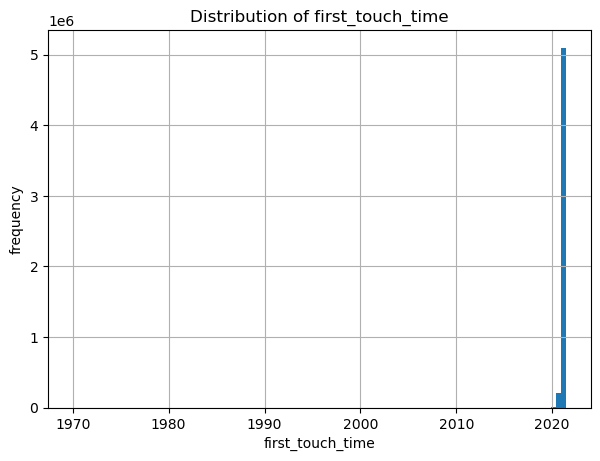

In [5]:
#take a look at user first touch datetime range 
events['first_touch_datetime'].hist(bins=100)
plt.title('Distribution of first_touch_time')
plt.xlabel('first_touch_time')
plt.ylabel('frequency')
plt.show()

There are a total of 78108 unique users, disregarding the possibility that some users might have uninstalled and then installed the app. Information in the 'first_touch_datetime' could be used to put users into cohorts. 

it's a little strange to see some first_touch_datetime date all the way back to the 70's, and date forward all the way to 2021-06-08, which is actually ahead of the event datetime. It would be useful to check why this is the case. 

For now, given that the most frequent first_touch_datetime is '2020-11-17', let's only keep those users who started after that. Before we slice the data, we need to see how many we will lose. 

In [6]:
events = events[events['first_touch_datetime'].notna()]

In [7]:
events[events['first_touch_datetime'] >= '2020-11-17'].shape[0]/len(events)

0.9798949241200262

Okay. It looks like about 2% of data will be excluded. It's not bad. We will go ahead and continue. 

In [8]:
events = events[events['first_touch_datetime'] >= '2020-11-17']

Given the data we have ranges slightly under 2 months, and the company's goal is to increase 28 day retention rate, let's divide the users into weekly cohorts adn track the cohort's retention rate by week. To this end, we will need a first_event_week and event_week. 

In [9]:
#calculate first event week 
events['first_event_week'] = pd.to_datetime(
    events['first_touch_datetime']) - pd.to_timedelta(events['first_touch_datetime'].dt.dayofweek, unit='d')
events['first_event_week'] = events['first_event_week'].dt.date
events['first_event_week'] = pd.to_datetime(events['first_event_week'])

In [10]:
#calculate event week 
events['event_week'] = pd.to_datetime(
    events['date']) - pd.to_timedelta(events['date'].dt.dayofweek, unit='d')

In [11]:
#calculate cohort lifetime
events['cohort_lifetime'] = events['event_week'] - events['first_event_week']
events['cohort_lifetime'] = events['cohort_lifetime'] / np.timedelta64(1, 'W') 
events['cohort_lifetime'] = events['cohort_lifetime'].astype(int)

In [12]:
events.head()

user_pseudo_id       event_name  event_value_in_usd  \
0  c2ded3a93cf43478a51822afa70a290a  user_engagement                 NaN   
1  71ce656cba181970cb7496405edee7a9    session_start                 NaN   
2  34b529ddc9e68ff98e95c82efbae5950         scr_home                 NaN   
3  34b529ddc9e68ff98e95c82efbae5950         scr_home                 NaN   
4  47bb7ae7e46808da7f52fd3fb81af604     survey_start                 NaN   

  platform  traffic  ltv device_category device_model continent  country  \
0  ANDROID  organic  NaN          mobile     SM-A715F    Europe  Germany   
1  ANDROID  organic  NaN          mobile     SM-A715F    Europe  Germany   
2  ANDROID  organic  NaN          mobile     SM-A715F    Europe  Germany   
3  ANDROID  organic  NaN          mobile     SM-A715F    Europe  Germany   
4  ANDROID  organic  NaN          mobile     SM-A715F    Europe  Germany   

  app_version       date            datetime   previous_datetime  \
0       2.5.8 2021-05-15 2021-05-15 04:49:08 2021-05-05 19:47:20   
1       2.5.8 2021-05-15 2021-05-15 07:58:54 2021-05-14 09:53:46   
2       2.5.8 2021-05-15 2021-05-15 09:56:44 2021-05-15 09:56:39   
3       2.5.8 2021-05-15 2021-05-15 09:57:06 2021-05-15 09:56:44   
4       2.5.8 2021-05-15 2021-05-15 04:52:47                 NaT   

  first_touch_datetime first_event_week event_week  cohort_lifetime  
0  2021-05-03 03:00:39       2021-05-03 2021-05-10                1  
1  2021-05-14 09:53:46       2021-05-10 2021-05-10                0  
2  2021-02-24 11:23:23       2021-02-22 2021-05-10               11  
3  2021-02-24 11:23:23       2021-02-22 2021-05-10               11  
4  2021-05-15 04:52:28       2021-05-10 2021-05-10                0

In [13]:
cohorts = (
    events.groupby(['first_event_week', 'cohort_lifetime'])
    .agg({'user_pseudo_id': 'nunique'})
    .reset_index()
) 
cohorts.head()

first_event_week  cohort_lifetime  user_pseudo_id
0       2020-11-16               20             329
1       2020-11-16               21             383
2       2020-11-16               22             398
3       2020-11-16               23             348
4       2020-11-16               24             328

Given the first event_date in the log starts on 2021-04-04, we won't be able to find out the cohort size of the earlier cohorts. Therefore, what we can do here is to use the number of unique users in the earliest cohort_lifetime on record as their cohort users. knowing that the number of active users later in the cohort lifetime can actually exceed the 'cohort_users' this way. 

In [14]:
#excluding negative values likely caused by error
cohorts = cohorts[cohorts['cohort_lifetime'] >=0]

Because not all the cohorts in the data have cohort 0, therefore we will take the earliest cohort's users' count as the initial users. For those who have 0 cohort lifetime, this will be the cohort size of the 0 lifetime cohort, whereas for others, it will be the size of their earliest cohort. 

In [15]:
initial_cohort_users = cohorts.groupby('first_event_week').agg(
    {'cohort_lifetime': 'first', 'user_pseudo_id': 'first'}).reset_index()
initial_cohort_users = initial_cohort_users.rename(
    columns={'user_pseudo_id': 'cohort_size'})
initial_cohort_users.tail(10)

first_event_week  cohort_lifetime  cohort_size
19       2021-03-29                1         1578
20       2021-04-05                0         5672
21       2021-04-12                0         7274
22       2021-04-19                0         7106
23       2021-04-26                0         5750
24       2021-05-03                0         5960
25       2021-05-10                0         5076
26       2021-05-17                0         4483
27       2021-05-24                0         4614
28       2021-05-31                0          606

For the last cohort, 2021-05-31, it is possible that the data is not complete at the time of the collection. Next, let's merge this with the cohorts dataset. 

In [16]:
cohorts = cohorts.merge(initial_cohort_users[['first_event_week', 'cohort_size']], on = 'first_event_week')
cohorts

first_event_week  cohort_lifetime  user_pseudo_id  cohort_size
0         2020-11-16               20             329          329
1         2020-11-16               21             383          329
2         2020-11-16               22             398          329
3         2020-11-16               23             348          329
4         2020-11-16               24             328          329
..               ...              ...             ...          ...
220       2021-05-17                1            1696         4483
221       2021-05-17                2             218         4483
222       2021-05-24                0            4614         4614
223       2021-05-24                1             747         4614
224       2021-05-31                0             606          606

[225 rows x 4 columns]

In [17]:
cohorts['retention'] = cohorts['user_pseudo_id'] / cohorts['cohort_size'] 

Given the span of the cohorts, for the purpose of this report, we will also present the cohort since 2021-04-05. 

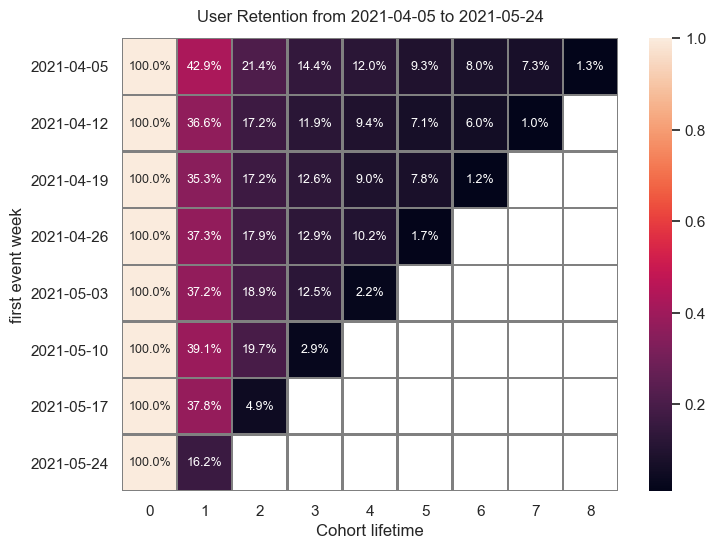

In [18]:
retention_pivot= cohorts[(cohorts['first_event_week'] >= '2021-04-05') & (cohorts['first_event_week'] < '2021-05-31')].pivot_table(
    index=cohorts['first_event_week'].apply(lambda x: x.strftime('%Y-%m-%d')),
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum'
)

sns.set(style='white')
plt.figure(figsize=(8, 6))
sns.heatmap(
    retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', annot_kws={"size": 9}
)
plt.title('User Retention from 2021-04-05 to 2021-05-24', pad=12)
plt.xlabel('Cohort lifetime')
plt.ylabel('first event week')
plt.show()

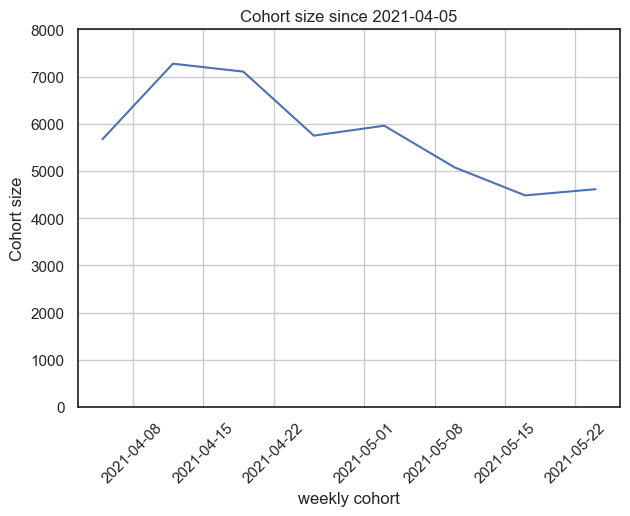

In [19]:
cohort_size = initial_cohort_users[(initial_cohort_users['first_event_week']
                      >= '2021-04-05') & (initial_cohort_users['first_event_week'] < '2021-05-31')]
sns.lineplot(data=cohort_size, y='cohort_size',x='first_event_week')
plt.title('Cohort size since 2021-04-05')
plt.xlabel('weekly cohort')
plt.ylim(0, 8000)
plt.grid()
plt.xticks(rotation=45)
plt.ylabel('Cohort size')
plt.show()

In [20]:
retention_pivot.fillna(0)

cohort_lifetime      0     1     2     3     4     5     6     7     8
first_event_week                                                      
2021-04-05       1.000 0.429 0.214 0.144 0.120 0.093 0.080 0.073 0.013
2021-04-12       1.000 0.366 0.172 0.119 0.094 0.071 0.060 0.010 0.000
2021-04-19       1.000 0.353 0.172 0.126 0.090 0.078 0.012 0.000 0.000
2021-04-26       1.000 0.373 0.179 0.129 0.102 0.017 0.000 0.000 0.000
2021-05-03       1.000 0.372 0.189 0.125 0.022 0.000 0.000 0.000 0.000
2021-05-10       1.000 0.391 0.197 0.029 0.000 0.000 0.000 0.000 0.000
2021-05-17       1.000 0.378 0.049 0.000 0.000 0.000 0.000 0.000 0.000
2021-05-24       1.000 0.162 0.000 0.000 0.000 0.000 0.000 0.000 0.000

In [21]:
retention_pivot.mean(axis=0)

cohort_lifetime
0   1.000
1   0.353
2   0.167
3   0.112
4   0.085
5   0.065
6   0.050
7   0.041
8   0.013
dtype: float64

Disregarding the last week in May, we can see a overall decline of cohort size. April 12th and 19th 2021 seem to have the largest cohort size. 

Despite the initial cohort size differ slightly, by the time it's their 4th cohort lifetime, on average it has dropped to 8%, far from what the company is hoping to achieve, 20%. 

Next, let's take a look at retention rate by country and by platform. We will only be looking at those whose first week events are after 2021-04-05. 

#### 1.2 Retention by region 

First let's find out which countries have the most norbu app users. 

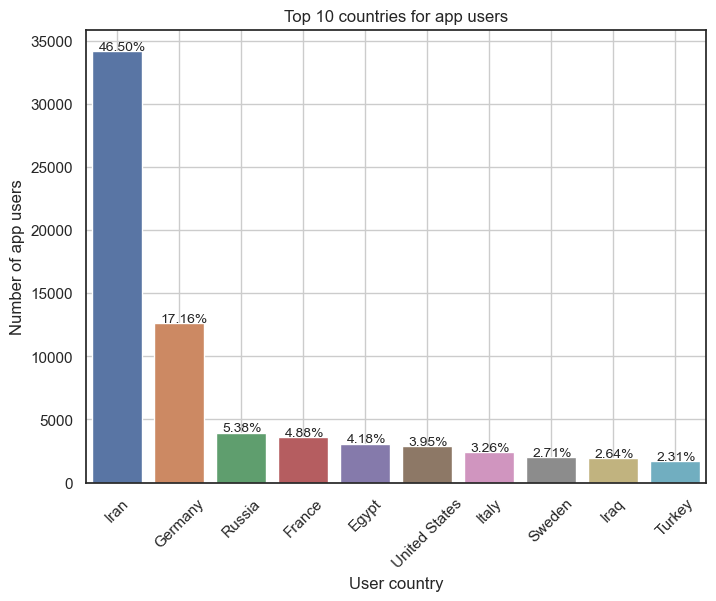

In [22]:
events_country = events.groupby('country').agg({'user_pseudo_id': 'nunique'}).reset_index().sort_values(
    by='user_pseudo_id', ascending=False).head(10)
fig, ax= plt.subplots(figsize =(8,6))
ax = sns.barplot(data = events_country, x='country', y='user_pseudo_id', ax=ax)
for p in ax.patches:
    percentage ='{:,.2%}'.format(p.get_height()/events['user_pseudo_id'].nunique())
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+0.1
    y=p.get_y()+height+100
    ax.annotate(percentage,(x,y), size=10)
plt.title('Top 10 countries for app users')
plt.xlabel('User country')
plt.ylabel('Number of app users')
plt.grid()
plt.xticks(rotation=45)
plt.show()

Okay. Iran really stands out as having the most app users. 

In [23]:
#Check the percentage of unique users
events.groupby('country').agg({'user_pseudo_id': 'nunique'}).sort_values(
    by='user_pseudo_id', ascending=False).head(10)/events['user_pseudo_id'].nunique()

user_pseudo_id
country                      
Iran                    0.465
Germany                 0.172
Russia                  0.054
France                  0.049
Egypt                   0.042
United States           0.039
Italy                   0.033
Sweden                  0.027
Iraq                    0.026
Turkey                  0.023

Iran alone accounts for almost 50% of the users and Germany comes next. In what follows, we can divide the users into three groups, those from Iran, from Germany, and from other countries to calculate the retention rates.

let's define a function that take dataframe as the input and the rention pivot table for the period of 2021-04-05 onwards as output.

In [24]:
def retention_pivot(df):
    df = df[df['first_event_week'] >= '2021-04-05']
    # getting cohort
    cohorts = (
        df.groupby(['first_event_week', 'cohort_lifetime'])
        .agg({'user_pseudo_id': 'nunique'})
        .reset_index()
    )
    # filter out those with cohort lifetime <0
    cohorts = cohorts[cohorts['cohort_lifetime'] >= 0]
    initial_cohort_users = cohorts.groupby('first_event_week').agg(
        {'cohort_lifetime': 'first', 'user_pseudo_id': 'first'}).reset_index()
    initial_cohort_users = initial_cohort_users.rename(
        columns={'user_pseudo_id': 'cohort_size'})
    cohorts = cohorts.merge(
        initial_cohort_users[['first_event_week', 'cohort_size']], on='first_event_week')
    cohorts['retention'] = cohorts['user_pseudo_id'] / cohorts['cohort_size']
    retention_pivot = cohorts.pivot_table(
        index=cohorts['first_event_week'].apply(
            lambda x: x.strftime('%Y-%m-%d')),
        columns='cohort_lifetime',
        values='retention',
        aggfunc='sum'
    )
    return retention_pivot

In [25]:
#retention pivot for Iran users 
retention_pivot(events[events['country'] == 'Iran'])

cohort_lifetime      0     1     2     3     4     5     6     7     8
first_event_week                                                      
2021-04-05       1.000 0.451 0.226 0.145 0.125 0.098 0.079 0.071 0.012
2021-04-12       1.000 0.410 0.191 0.130 0.101 0.080 0.063 0.010   NaN
2021-04-19       1.000 0.378 0.198 0.131 0.100 0.078 0.012   NaN   NaN
2021-04-26       1.000 0.404 0.184 0.142 0.110 0.020   NaN   NaN   NaN
2021-05-03       1.000 0.388 0.197 0.122 0.020   NaN   NaN   NaN   NaN
2021-05-10       1.000 0.419 0.215 0.034   NaN   NaN   NaN   NaN   NaN
2021-05-17       1.000 0.385 0.054   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-24       1.000 0.169   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-31       1.000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [26]:
retention_pivot(events[events['country'] == 'Iran']).mean(axis=0)

cohort_lifetime
0   1.000
1   0.375
2   0.181
3   0.117
4   0.091
5   0.069
6   0.051
7   0.041
8   0.012
dtype: float64

At 4th week, the retention rate on average among Iranian users is about 9%. 

In [27]:
retention_pivot(events[events['country'] == 'Germany'])

cohort_lifetime      0     1     2     3     4     5     6     7     8
first_event_week                                                      
2021-04-05       1.000 0.412 0.138 0.139 0.130 0.112 0.085 0.088 0.009
2021-04-12       1.000 0.338 0.176 0.164 0.105 0.080 0.082 0.009   NaN
2021-04-19       1.000 0.479 0.216 0.181 0.093 0.099 0.009   NaN   NaN
2021-04-26       1.000 0.381 0.164 0.097 0.090 0.006   NaN   NaN   NaN
2021-05-03       1.000 0.373 0.155 0.096 0.007   NaN   NaN   NaN   NaN
2021-05-10       1.000 0.341 0.167 0.013   NaN   NaN   NaN   NaN   NaN
2021-05-17       1.000 0.388 0.024   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-24       1.000 0.080   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-31       1.000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [28]:
retention_pivot(events[events['country'] == 'Germany']).mean(axis=0)

cohort_lifetime
0   1.000
1   0.349
2   0.149
3   0.115
4   0.085
5   0.074
6   0.059
7   0.048
8   0.009
dtype: float64

At 4th week, the retention rate on average among Iranian users is about 8.5%. 

Essentially, the Iranian and German users show retention rate similar to the overall retention rate. 

#### 1.3 retention rate by platform

In [29]:
events['platform'].value_counts()

ANDROID    5009213
IOS         193349
Name: platform, dtype: int64

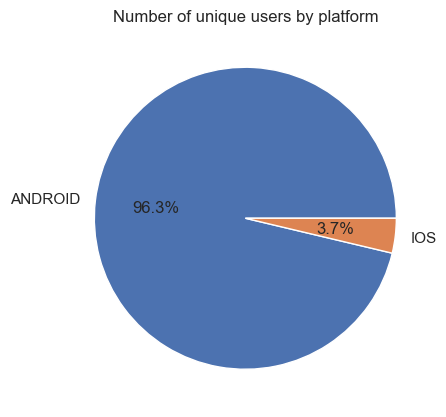

In [30]:
events['platform'].value_counts().plot.pie(autopct="%.1f%%")
plt.ylabel('')
plt.title('Number of unique users by platform')
plt.show()

In [31]:
retention_pivot(events[events['platform'] == 'ANDROID'])

cohort_lifetime      0     1     2     3     4     5     6     7     8
first_event_week                                                      
2021-04-05       1.000 0.436 0.221 0.149 0.123 0.096 0.083 0.075 0.013
2021-04-12       1.000 0.384 0.182 0.127 0.101 0.076 0.063 0.010   NaN
2021-04-19       1.000 0.366 0.179 0.132 0.094 0.082 0.012   NaN   NaN
2021-04-26       1.000 0.376 0.180 0.129 0.102 0.017   NaN   NaN   NaN
2021-05-03       1.000 0.374 0.191 0.126 0.022   NaN   NaN   NaN   NaN
2021-05-10       1.000 0.394 0.197 0.029   NaN   NaN   NaN   NaN   NaN
2021-05-17       1.000 0.381 0.050   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-24       1.000 0.161   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-31       1.000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [32]:
retention_pivot(events[events['platform'] == 'ANDROID']).mean(axis=0)

cohort_lifetime
0   1.000
1   0.359
2   0.171
3   0.115
4   0.088
5   0.068
6   0.053
7   0.043
8   0.013
dtype: float64

In [33]:
retention_pivot(events[events['platform'] == 'IOS'])

cohort_lifetime      0     1     2     3     4     5     6     7     8
first_event_week                                                      
2021-04-05       1.000 0.294 0.090 0.052 0.073 0.038 0.017 0.035 0.014
2021-04-12       1.000 0.196 0.079 0.044 0.027 0.030 0.028 0.007   NaN
2021-04-19       1.000 0.187 0.090 0.061 0.034 0.032 0.013   NaN   NaN
2021-04-26       1.000 0.244 0.130 0.138 0.089 0.008   NaN   NaN   NaN
2021-05-03       1.000 0.278 0.111 0.056 0.024   NaN   NaN   NaN   NaN
2021-05-10       1.000 0.270 0.191 0.026   NaN   NaN   NaN   NaN   NaN
2021-05-17       1.000 0.289 0.014   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-24       1.000 0.202   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2021-05-31       1.000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN

In [34]:
retention_pivot(events[events['platform'] == 'IOS']).mean(axis=0)

cohort_lifetime
0   1.000
1   0.245
2   0.101
3   0.063
4   0.049
5   0.027
6   0.020
7   0.021
8   0.014
dtype: float64

On average, by the 4th week, Android users' retention rate is about 8.8%, whereas IOS user' retention rate is about 4.9%. 

There is a big different between the platform users. Is it possible that the app is more android friendly? 

#### 1.4 retention rate by traffic medium 

In [35]:
events['traffic'].value_counts()/len(events)

organic              0.892
(none)               0.097
share                0.001
Download ButtonRu    0.001
Download ButtonEng   0.000
ntf                  0.000
sm                   0.000
insta                0.000
banner               0.000
app                  0.000
Download ButtonPt    0.000
Name: traffic, dtype: float64

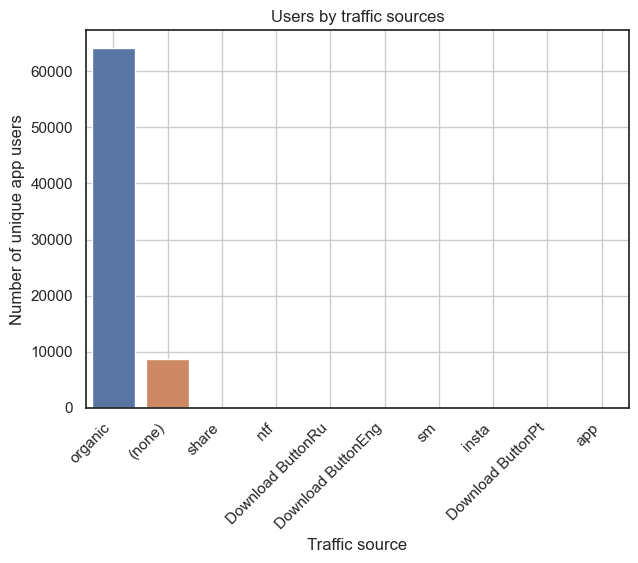

In [36]:
events_traffic = events.groupby('traffic').agg({'user_pseudo_id': 'nunique'}).reset_index().sort_values(
    by='user_pseudo_id', ascending=False).head(10)
sns.barplot(data = events_traffic, x='traffic', y='user_pseudo_id')
plt.title('Users by traffic sources')
plt.xlabel('Traffic source')
plt.ylabel('Number of unique app users')
plt.grid()
plt.xticks(rotation=45,ha='right')
plt.show()

In [37]:
events_traffic['percentage_users'] = events_traffic['user_pseudo_id']/events['user_pseudo_id'].nunique()
events_traffic

traffic  user_pseudo_id  percentage_users
8              organic           64082             0.872
0               (none)            8701             0.118
9                share             106             0.001
7                  ntf              63             0.001
3    Download ButtonRu              29             0.000
1   Download ButtonEng              17             0.000
10                  sm               4             0.000
6                insta               2             0.000
2    Download ButtonPt               1             0.000
4                  app               1             0.000

Let's divide the user into two groups, those are from organic sources, and those are not. 

In [38]:
retention_pivot(events[events['traffic'] == 'organic']).mean(axis=0)

cohort_lifetime
0   1.000
1   0.359
2   0.171
3   0.114
4   0.087
5   0.067
6   0.051
7   0.042
8   0.013
dtype: float64

In [39]:
retention_pivot(events[events['traffic'] != 'organic']).mean(axis=0)

cohort_lifetime
0   1.000
1   0.308
2   0.147
3   0.099
4   0.077
5   0.052
6   0.045
7   0.036
8   0.021
dtype: float64

By the 4th lifetime week, there is a slightly higher retention rate among users coming from organic sources (8.7%) than from non-organic sources (7.7%)

### 2. User LTV

<a id="ltv"></a>

Let's first address the task of calculating user LTV. The dataset made it easy for us because there is already a LTV column. We will use it to perform the following analysis. 

- overall user LTV
- user LTV by country
- user LTV by traffic source
- user LTV by Platform
- user LTV revenue

Given the ltv in the dataset is accumulative for each user. The most recent(last) ltv is the ltv for each user. 

In [40]:
#read the data if needed
#events = pd.read_pickle("/Users/xiac/Documents/Yandex/norbu_project/events_.pkl")

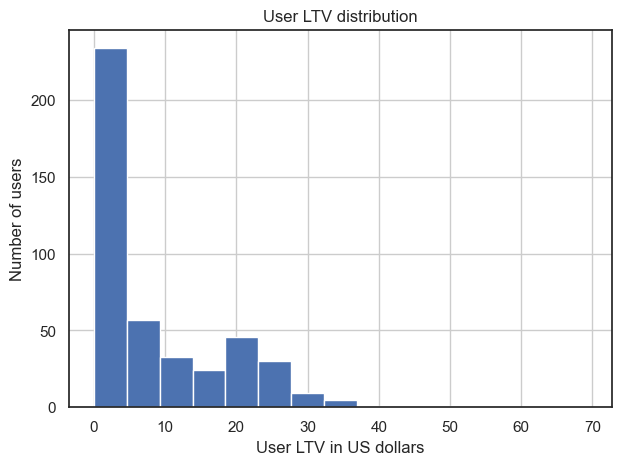

In [41]:
#build a histogram to show user ltv
events.groupby('user_pseudo_id').agg({'ltv': 'last'}).hist(bins=15)
plt.title('User LTV distribution')
plt.xlabel('User LTV in US dollars')
plt.ylabel('Number of users')
plt.show()

In [42]:
events['user_pseudo_id'].nunique()

73472

In [43]:
#check the ltv column
events.groupby('user_pseudo_id').agg({'ltv': 'last'}).describe()

ltv
count 441.000
mean    8.866
std     9.637
min     0.000
25%     2.340
50%     4.184
75%    15.407
max    69.255

In [44]:
events.groupby('user_pseudo_id').agg({'ltv': 'last'}).sum()

ltv   3910.066
dtype: float64

Okay. From the above we can see that only 441 unique users have values in ltv column, half of whom has an LTV under 5 US dollars. By 2021-5-31, the total lifetime values by users are about 3910 US dollars. 

(note: here the result is based on events after filtering out the 'first_touch_time' before 2020-11-17. Results may chang slightly if the filtering is not done. )

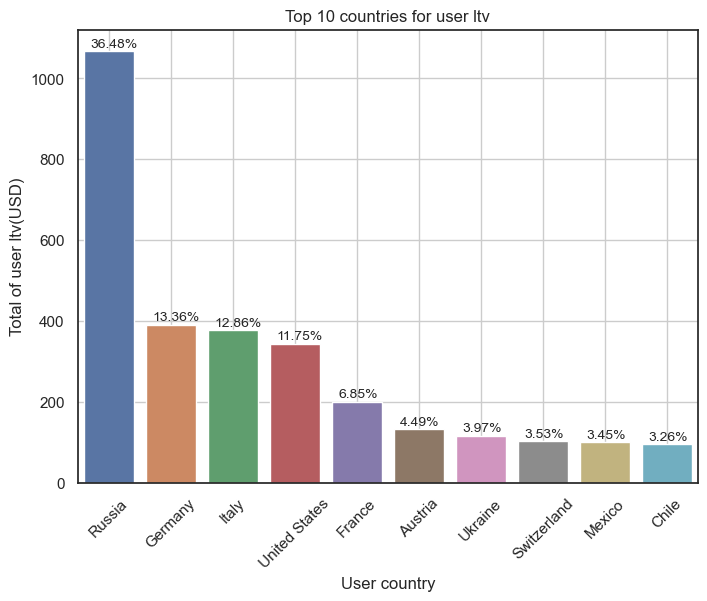

In [45]:
events_ltv = events.groupby('user_pseudo_id').agg(
    {'country': 'last', 'ltv': 'last'}).reset_index().groupby('country').agg({
        'ltv': 'sum'}).reset_index().sort_values(by='ltv', ascending=False).head(10)

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(data=events_ltv, x='country', y='ltv', ax=ax)
for p in ax.patches:
    percentage = '{:,.2%}'.format(
        p.get_height()/events_ltv['ltv'].sum())
    width, height = p.get_width(), p.get_height()
    x = p.get_x()+0.1
    y = p.get_y()+height+10
    ax.annotate(percentage, (x, y), size=10)
plt.title('Top 10 countries for user ltv')
plt.xlabel('User country')
plt.ylabel('Total of user ltv(USD)')
plt.grid()
plt.xticks(rotation=45)
plt.show()

Although Iran seems to have the most users, Russia tops the list in terms of its total user ltv. Germany comes second. It's interesting to notice that Iran is not among the top 10 countries as far as user ltv is concerned. 

In [46]:
events.groupby('user_pseudo_id').agg(
    {'platform': 'last', 'ltv': 'last'}).reset_index().groupby('platform').agg({
    'ltv': ['sum','mean']}).reset_index()

platform      ltv       
                sum   mean
0  ANDROID 3030.139  8.167
1      IOS  879.927 12.570

Most of the users are android users, so it makes sense that they generate most of the ltv as well. However, it's intersting to see IOS users have a higher average user ltv. 

In [47]:
events.groupby('user_pseudo_id').agg(
    {'traffic': 'last', 'ltv': 'last'}).reset_index().groupby('traffic').agg({
    'ltv': ['sum','mean']}).reset_index()

traffic      ltv       
                            sum   mean
0               (none) 1315.557 11.244
1   Download ButtonEng    0.000    NaN
2    Download ButtonPt    0.000    NaN
3    Download ButtonRu   21.166  5.292
4                  app    0.000    NaN
5               banner    0.000    NaN
6                insta    0.000    NaN
7                  ntf    0.000    NaN
8              organic 2536.472  8.027
9                share   16.815  8.407
10                  sm    0.000    NaN

Organic users contribute to majority of the user ltv. Unknown source users seem to have the highest average user ltv. It would be interesting to find out why these users sources are unknown. 

Overall, in this section, we take a look at user ltv. One of the tasks from the company is what affects user ltv. At this stage, it's not certain that this information can be generated from the data. 

### 3.  Top user events

<a id="top"></a>

Let's take a look at what are the most popular user events. 

In [48]:
#download the data if needed
event_params = pd.read_pickle('/Users/xiac/Documents/Yandex/norbu_project/event_params.pkl')

In [49]:
events = pd.read_pickle("/Users/xiac/Documents/Yandex/norbu_project/events_.pkl")

In [50]:
#check out the event names
with pd.option_context('display.max_rows', None):
    display(events['event_name'].value_counts().head(10))

scr_home                574287
scr_training_details    510796
user_engagement         355542
scr_brain_progress      304270
screen_view             219422
scr_breathe_home        214562
session_start           194962
scr_ballshome           194087
scr_breathe             192827
scr_ballsgame           188211
Name: event_name, dtype: int64

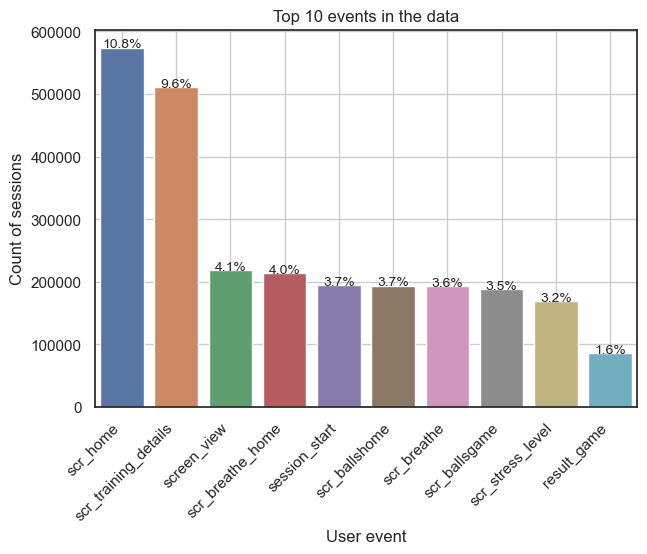

In [51]:
#plot the top 10 events
data = events[(events['event_name'] != 'user_engagement') &
              (events['event_name'] != 'scr_brain_progress')]
top_event = data.groupby('event_name').agg({'date': 'count'}).reset_index(
).sort_values(by='date', ascending=False).head(10)
ax = sns.barplot(data=top_event, x='event_name', y='date')
plt.title('Top 10 events in the data')
plt.xlabel('User event')
plt.ylabel('Count of sessions')
plt.grid()
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(events))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', size=10)
plt.xticks(rotation=45, ha='right')
plt.show()

From the above, we can see that app home screen, as we would expect, is the most visited session. The training details screen, breathe homescreen, ball game homescreen and stress management home screen also seem to be popular among users. In what follows, we will be looking at these one by one. 

Before we move on to analyze individual events, we will need to join the 2 datasets so we have both event parameters and user information in the same data. 

In [52]:
#join by index
events_ = events.join(event_params['event_params'])

### 4. A user journey function

<a id="journey"></a>

Let's define a function here to plot user journey. The parameters to use when using the functions are: the events data, the session that is decided to be the first session, how many steps the journey will track for, how many parallel paths are to keep (the rest will be grouped as other). 

In [53]:
def filter_starting_step(x, starting_step, n_steps):
    """
    Function used to return the first n_steps for each user starting from the "starting_step".
    The function will be used to generate the event sequence journey for each user.
    """
    starting_step_index = x.index(starting_step)
    
    return x[starting_step_index: starting_step_index + n_steps] 

def user_journey(events, starting_step, n_steps=3, events_per_step=5):
    """
    Function used to map out the journey for each user starting from the defined "starting_step" and count
    how many identical journeys exist across users.
    """
    # sort events by time
    events = events.sort_values(['user_pseudo_id', 'datetime'])
    # find the users that have performed the starting_step
    valid_ids = events[events['event_name'] == starting_step]['user_pseudo_id'].unique()

    # plan out the journey per user, with each step in a separate column
    flow = events[(events['user_pseudo_id'].isin(valid_ids))] \
        .groupby('user_pseudo_id') \
        .event_name.agg(list) \
        .to_frame()['event_name'] \
        .apply(lambda x: filter_starting_step(x, starting_step=starting_step, n_steps=n_steps)) \
        .to_frame() \
        ['event_name'].apply(pd.Series)

    # fill NaNs with "End" to denote no further step by user; this will be filtered out later
    flow = flow.fillna('End')

    # add the step number as prefix to each step
    for i, col in enumerate(flow.columns):
        flow[col] = '{}: '.format(i + 1) + flow[col].astype(str)

    # replace events not in the top "events_per_step" most frequent list with the name "Other"
    # this is done to avoid having too many nodes in the sankey diagram
    for col in flow.columns:
        all_events = flow[col].value_counts().index.tolist()
        all_events = [e for e in all_events if e != (str(col + 1) + ': End')]
        top_events = all_events[:events_per_step]
        to_replace = list(set(all_events) - set(top_events))
        flow[col].replace(to_replace, [str(col + 1) + ': Other'] * len(to_replace), inplace=True)

    # count the number of identical journeys up the max step defined
    flow = flow.groupby(list(range(n_steps))) \
        .size() \
        .to_frame() \
        .rename({0: 'count'}, axis=1) \
        .reset_index()

    return flow

def sankey_df(events, starting_step, n_steps=3, events_per_step=5):
    """
    Function used to generate the dataframe needed to be passed to the sankey generation function.
    "source" and "target" column pairs denote links that will be shown in the sankey diagram.
    """
    # generate the user user flow dataframe
    flow = user_journey(events, starting_step, n_steps, events_per_step)

    # create the nodes labels list
    label_list = []
    cat_cols = flow.columns[:-1].values.tolist()
    for cat_col in cat_cols:
        label_list_temp = list(set(flow[cat_col].values))
        label_list = label_list + label_list_temp

    # create a list of colours for the nodes
    # assign 'blue' to any node and 'grey' to "Other" nodes
    colors_list = ['blue' if i.find('Other') < 0 else 'grey' for i in label_list]

    # transform flow df into a source-target pair
    for i in range(len(cat_cols) - 1):
        if i == 0:
            source_target_df = flow[[cat_cols[i], cat_cols[i + 1], 'count']]
            source_target_df.columns = ['source', 'target', 'count']
        else:
            temp_df = flow[[cat_cols[i], cat_cols[i + 1], 'count']]
            temp_df.columns = ['source', 'target', 'count']
            source_target_df = pd.concat([source_target_df, temp_df])
        source_target_df = source_target_df.groupby(['source', 'target']).agg({'count': 'sum'}).reset_index()

    # add index for source-target pair
    source_target_df['source_id'] = source_target_df['source'].apply(lambda x: label_list.index(x))
    source_target_df['target_id'] = source_target_df['target'].apply(lambda x: label_list.index(x))

    # filter out the end step
    source_target_df = source_target_df[(~source_target_df['source'].str.contains('End')) &
                                        (~source_target_df['target'].str.contains('End'))]

    return label_list, colors_list, source_target_df

def plot_user_flow(events, starting_step, n_steps=3, events_per_step=5, title='Sankey Diagram'):
    """
    Function used to generate the sankey plot for user journeys.
    """
    # transform raw events dataframe into  source:target pairs including node ids and count of each combination
    label_list, colors_list, source_target_df = sankey_df(events, starting_step, n_steps, events_per_step)

    # creating the sankey diagram
    data = go.Sankey(
        node=dict(
            pad=20,
            thickness=20,
            color=colors_list,
            line=dict(
                color="black",
                width=0.5
            ),
            label=label_list
        ),
        link=dict(
            source=source_target_df['source_id'].values.tolist(),
            target=source_target_df['target_id'].values.tolist(),
            value=source_target_df['count'].astype(int).values.tolist(),
            hoverlabel=dict(
                bgcolor='#C2C4C7')
        )
    )

    # set window width so that steps are evenly spaced out
    if n_steps < 5:
        width = None
    else:
        width = n_steps * 250

    layout = dict(
        height=600,
        width=width,
        margin=dict(t=30, l=0, r=0, b=30),
        title=title,
        font=dict(
            size=10
        )
    )

    fig = go.Figure(data=[data], layout=layout)
    return fig.show()

### 5. User stress assessment 

<a id="stress"></a>

In [54]:
#slice the stress management training related data 
events_stress = events_[events_['event_name'] == 'scr_stress_level']
print(events_stress.shape[0])
events_stress.sample(5)

169754


user_pseudo_id        event_name  \
5191610  ededd30e5bf41b0df785f14373c06b58  scr_stress_level   
1636473  9433C8D08EF94D1B91946DD43B5E2753  scr_stress_level   
2518497  06075c0be8da023a3dc8e2e239b058df  scr_stress_level   
4658806  304c57d25cbf1b1c7bf082951bcfba90  scr_stress_level   
3882216  9872f65653a32c8c65d9a4bf1816ebb3  scr_stress_level   

         event_value_in_usd platform  traffic   ltv device_category  \
5191610                 NaN  ANDROID  organic   NaN          mobile   
1636473                 NaN      IOS   (none)   NaN          mobile   
2518497                 NaN  ANDROID  organic   NaN          mobile   
4658806                 NaN  ANDROID  organic   NaN          mobile   
3882216                 NaN  ANDROID  organic 3.984          mobile   

        device_model continent  country app_version       date  \
5191610     SM-A315F      Asia     Iran       2.5.8 2021-05-27   
1636473       iPhone    Europe   Russia       2.5.8 2021-05-15   
2518497     SM-A217F    Europe  Germany       2.5.7 2021-04-18   
4658806      ATU-L31      Asia     Iran       2.6.1 2021-05-27   
3882216      ELE-L04  Americas   Mexico       2.5.8 2021-05-22   

                   datetime   previous_datetime first_touch_datetime  \
5191610 2021-05-27 06:02:24 2021-05-27 06:02:22  2020-11-17 11:06:22   
1636473 2021-05-15 19:20:59 2021-05-15 19:09:07  2021-05-12 18:15:29   
2518497 2021-04-18 10:13:23 2021-04-18 10:03:36  2021-04-18 10:00:48   
4658806 2021-05-27 06:35:01 2021-05-27 06:35:01  2021-05-27 06:17:28   
3882216 2021-05-22 03:39:03 2021-05-22 03:38:56  2021-05-17 05:06:34   

                                              event_params  
5191610  [{'key': 'firebase_screen_id', 'value': {'stri...  
1636473  [{'key': 'ga_session_id', 'value': {'string_va...  
2518497  [{'key': 'firebase_screen_id', 'value': {'stri...  
4658806  [{'key': 'ga_session_number', 'value': {'strin...  
3882216  [{'key': 'ga_session_number', 'value': {'strin...

In [55]:
events_stress.sample().values

array([['2bd99f47a7276331d0f3305cbdc8e44e', 'scr_stress_level', nan,
        'ANDROID', 'share', nan, 'mobile', 'moto g(9) power', 'Americas',
        'Chile', '2.5.7', Timestamp('2021-04-15 00:00:00'),
        Timestamp('2021-04-15 20:47:21'),
        Timestamp('2021-04-15 20:47:11'),
        Timestamp('2021-04-14 17:24:55'),
        array([{'key': 'firebase_screen_id', 'value': {'string_value': None, 'int_value': -1.2808684504851796e+18, 'float_value': None, 'double_value': None}},
               {'key': 'firebase_event_origin', 'value': {'string_value': 'app', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'ga_session_id', 'value': {'string_value': None, 'int_value': 1618518724.0, 'float_value': None, 'double_value': None}},
               {'key': 'engaged_session_event', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}},
               {'key': 'firebase_screen_class', 'value': {'string_value': 'Main

From above, we can see that users arrived at the screen where they are asked to rate their stress 169,754 times. 

In [56]:
#slice data to get before and after training stressing rating data 
stress_level = events_[events_['event_name'] == 'result_session']
print('Number of stress evaluations completed:', stress_level.shape[0])
print(stress_level.shape[0] / events_stress.shape[0])

Number of stress evaluations completed: 22913
0.13497767357470222


In [57]:
stress_funnel = go.Figure(go.Funnel(
    y=['scr_stress_level', 'result_session'],
    x=[events_stress.shape[0], stress_level.shape[0]],
    textposition="inside",
    textinfo="value+percent initial"
))

stress_funnel.update_layout(title={
    'text': "From stress level screen to session results",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    width=800, height=600)

stress_funnel.show()

Among those, a total of 22913 results sessions have been activiated which have a before and after stress level self evaluation. This represents approximately 13% of the total sessions at home screen of stress level. 

Next, let's extract the results from the event parameters. 

In [58]:
#plot the user journey from stress management home screen 
plot_user_flow(events, 'scr_stress_level', 5, 5, title = 'From scr_stress_level')

Next, let's take a look at the user before and after stress level self assessment. 

In [59]:
#define the function to extract the before and after stress level. 
def extract_stress_before(lst):
    for dic in lst:
        if dic['key'] == 'before':
            return dic['value']['double_value']
def extract_stress_after(lst):
    for dic in lst:
        if dic['key'] == 'after':
            return dic['value']['double_value']

In [60]:
#add the before and after stress level columns
stress_level['before'] = stress_level['event_params'].apply(lambda x: extract_stress_before(x))
stress_level['after'] = stress_level['event_params'].apply(lambda x: extract_stress_after(x))
stress_level.head()

user_pseudo_id      event_name  event_value_in_usd  \
40    4db194801270e9ac1a68ce24ff42ebb0  result_session                 NaN   
646   73bb76c50bdbc99bda0904df1aa6feae  result_session                 NaN   
1015  358f515c2e83440693ee9a2ea41783c4  result_session                 NaN   
1636  e89ab5c12596df3899883c1d0d8ba2b7  result_session                 NaN   
1665  99babbe2b802f25eeccf2ca695d229f6  result_session                 NaN   

     platform  traffic  ltv device_category device_model continent  country  \
40    ANDROID  organic  NaN          mobile     SM-G973F    Europe  Germany   
646   ANDROID  organic  NaN          mobile      DUB-LX1      Asia     Iran   
1015  ANDROID  organic  NaN          mobile   Mi Note 10      Asia     Iran   
1636  ANDROID  organic  NaN          mobile     SM-J710F      Asia     Iran   
1665  ANDROID  organic  NaN          mobile     SM-J710F      Asia     Iran   

     app_version       date            datetime   previous_datetime  \
40         2.5.8 2021-05-15 2021-05-15 19:21:56 2021-05-14 19:56:39   
646        2.5.7 2021-04-21 2021-04-21 14:04:55                 NaT   
1015       2.6.1 2021-05-31 2021-05-31 17:59:27                 NaT   
1636       2.5.8 2021-05-01 2021-05-01 09:09:37                 NaT   
1665       2.5.7 2021-05-01 2021-05-01 11:23:12                 NaT   

     first_touch_datetime                                       event_params  \
40    2021-05-13 19:11:27  [{'key': 'firebase_screen_id', 'value': {'stri...   
646   2021-04-21 13:49:21  [{'key': 'engaged_session_event', 'value': {'s...   
1015  2021-05-31 13:07:53  [{'key': 'firebase_screen_class', 'value': {'s...   
1636  2021-05-01 06:15:51  [{'key': 'before', 'value': {'string_value': N...   
1665  2021-04-27 08:13:06  [{'key': 'firebase_conversion', 'value': {'str...   

      before  after  
40     9.000  8.000  
646    1.000  0.000  
1015   2.000  0.000  
1636   7.000  0.000  
1665   9.000  3.000

In [61]:
#change the values to integers, and add a change column to show stress level change
stress_level['before'] = stress_level['before'].astype('int')
stress_level['after'] = stress_level['after'].astype('int')
stress_level['change'] = stress_level['before'] - stress_level['after']

In [62]:
len(stress_level)

22913

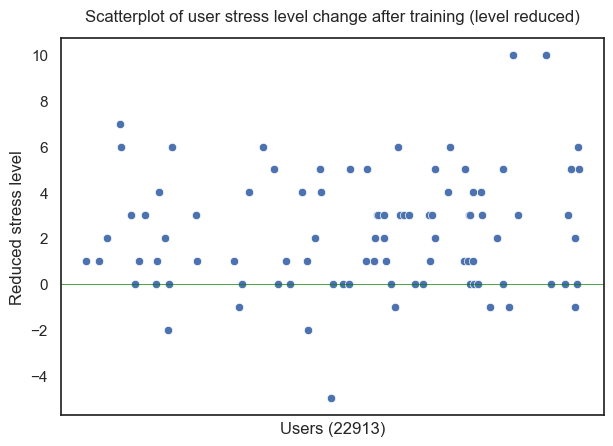

In [63]:
#Plot stress level change
sns.scatterplot(x = pd.Series(range(0, len(stress_level))), 
                y=stress_level['change'])
plt.axhline(y=0, color = 'green', linewidth = 0.5)
plt.title('Scatterplot of user stress level change after training (level reduced)', pad = 12)
plt.ylabel('Reduced stress level')
plt.xlabel('Users (22913)')
plt.xticks([])
plt.show()

In [64]:
stress_level[stress_level['change']>0].shape[0] / stress_level.shape[0]

0.7880679090472658

As shown in this section, from scr_stress_level to result_session, approximately **13%** of the time (22913/169754) users actually start and complete a training session and trigger a before and after stress evaluation result. 

For completed user sessions, we can see that most of these result in reduced stress level, at approximately 78.8%. 

In [65]:
stress_level.groupby('country').agg(
    {'before': 'median', 'user_pseudo_id': 'nunique'}).sort_values(by=['user_pseudo_id', 'before'], ascending=False).head(10)

before  user_pseudo_id
country                              
Iran            5.000            5749
Germany         5.000            1472
Russia          4.000             723
France          5.000             382
Italy           5.000             360
Egypt           6.000             356
Turkey          6.000             305
Iraq            5.000             235
United States   5.000             208
Sweden          6.000             173

A quick look at the median before session stress level by country for the top 10 countries with the most users shows the the values ranging between 4 to 6. Russian has the lowest self assessed before stress level. 

### 6. Survey analysis

<a id="survey"></a>

In [66]:
#slice survey data
events_survey = events_[events_['event_name'].str.contains('survey')]
print(events_survey.shape[0])
events_survey.head()

304328


user_pseudo_id         event_name  event_value_in_usd  \
4   47bb7ae7e46808da7f52fd3fb81af604       survey_start                 NaN   
33  c993cd4752077dc4b7101c1fc5d5a7f6         survey_end                 NaN   
37  6661655f1eadb8b2d7b8cd98daab8d3c         scr_survey                 NaN   
67  abc4e6cfd409e77a1e19123d18ef730f  scr_survey_result                 NaN   
76  5613d30e49bfdd3e795adf69fe0ebb3a         scr_survey                 NaN   

   platform  traffic  ltv device_category device_model continent  country  \
4   ANDROID  organic  NaN          mobile     SM-A715F    Europe  Germany   
33  ANDROID  organic  NaN          mobile     SM-G955F    Europe  Germany   
37  ANDROID  organic  NaN          mobile     SM-G960F    Europe  Germany   
67  ANDROID  organic  NaN          mobile     SM-J106F    Europe  Germany   
76  ANDROID  organic  NaN          mobile     SM-J500H    Europe  Germany   

   app_version       date            datetime   previous_datetime  \
4        2.5.8 2021-05-15 2021-05-15 04:52:47                 NaT   
33       2.5.8 2021-05-15 2021-05-15 19:48:49                 NaT   
37       2.5.8 2021-05-15 2021-05-15 08:14:29 2021-05-15 06:34:56   
67       2.5.8 2021-05-15 2021-05-15 14:21:33                 NaT   
76       2.5.8 2021-05-15 2021-05-15 10:29:16 2021-05-13 07:16:00   

   first_touch_datetime                                       event_params  
4   2021-05-15 04:52:28  [{'key': 'firebase_screen_id', 'value': {'stri...  
33  2021-05-15 19:46:24  [{'key': 'domain6', 'value': {'string_value': ...  
37  2021-05-15 06:34:50  [{'key': 'ga_session_number', 'value': {'strin...  
67  2021-05-14 17:41:35  [{'key': 'firebase_event_origin', 'value': {'s...  
76  2021-05-12 19:15:01  [{'key': 'ga_session_number', 'value': {'strin...

Lets' next plot a funnel from survey homescreen to end of survey.

In [67]:
survey_events = events_survey[(events_survey['event_name'] == 'scr_survey') | (
    events_survey['event_name'] == 'survey_start') | (
    events_survey['event_name'] == 'scr_survey_result') | (
    events_survey['event_name'] == 'survey_end')]['event_name'].value_counts()

In [68]:
stress_funnel = go.Figure(go.Funnel(
    y=survey_events.index,
    x=survey_events.values,
    textposition="inside",
    textinfo="value+percent initial"
))

stress_funnel.update_layout(title={
    'text': "From survey homescreen to survey results",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    width=800, height=600)

stress_funnel.show()

From the above, we can see that there are 68529 sessions on the survey screen, among those, 62941 progress to start the survey, and 47851 completed the survey to have generated a score against the 6 domains. 

In [69]:
#plot the user journey from survey homescreen
plot_user_flow(events, 'scr_survey', 5, 5, title = 'From survey homescreen')

Let's take a closer look at the survey results.

In [70]:
survey_results = events_survey[events_survey['event_name'] == 'survey_end']
survey_results.shape[0]

47851

In [71]:
# define a function to add survey results columns
def extract_survey_score(lst):
    for dic in lst:
        if dic['key'] == key:
            return dic['value']['double_value']


for key in ['domain1', 'domain2', 'domain3', 'domain4', 'domain5', 'domain6']:
    survey_results[key] = survey_results['event_params'].apply(
        lambda x: extract_survey_score(x))

In [72]:
#check out one row in details
survey_results.sample().values

array([['744854c01b4a44c1ec4a3c0665bf928b', 'survey_end', nan, 'ANDROID',
        'organic', nan, 'mobile', 'Mi 9 Lite', 'Asia', 'Iran', '2.5.7',
        Timestamp('2021-04-21 00:00:00'),
        Timestamp('2021-04-21 07:23:12'), NaT,
        Timestamp('2021-04-21 07:20:58'),
        array([{'key': 'engaged_session_event', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}},
               {'key': 'domain2', 'value': {'string_value': None, 'int_value': None, 'float_value': None, 'double_value': 4.8}},
               {'key': 'firebase_screen_class', 'value': {'string_value': 'MainActivity', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'domain3', 'value': {'string_value': None, 'int_value': None, 'float_value': None, 'double_value': 4.0}},
               {'key': 'date', 'value': {'string_value': '2021-04-21T11:51:35.198198', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'

In the event_param, the dictionaries with domain1 to domain 6 as keys are where the survey results are stored. 

In [73]:
#restore the domain names
survey_results = survey_results.rename(columns = {'domain1':'emotional_stability',
                                                  'domain2':'body_tonus',
                                                  'domain3':'life_satisfaction',
                                                  'domain4':'active_attitude',
                                                  'domain5':'calmness',
                                                  'domain6':'sleep_norm'})

In [74]:
survey_results.head()

user_pseudo_id  event_name  event_value_in_usd  \
33   c993cd4752077dc4b7101c1fc5d5a7f6  survey_end                 NaN   
235  7e9f88fff14c95869f78d44184b0ca19  survey_end                 NaN   
309  8e97c4782bd40c68153307e7fcff0b99  survey_end                 NaN   
387  f29a822245d82ddc5bca6bfb0bb009d0  survey_end                 NaN   
433  4d19028f15d18a7071a2114cea92d777  survey_end                 NaN   

    platform  traffic  ltv device_category      device_model continent  \
33   ANDROID  organic  NaN          mobile          SM-G955F    Europe   
235  ANDROID  organic  NaN          mobile        M2003J15SC    Europe   
309  ANDROID  organic  NaN          mobile      Redmi Note 8    Europe   
387  ANDROID  organic  NaN          mobile  Redmi Note 9 Pro    Europe   
433  ANDROID  organic  NaN          mobile     Redmi Note 9S      Asia   

     country  ...            datetime   previous_datetime  \
33   Germany  ... 2021-05-15 19:48:49                 NaT   
235  Germany  ... 2021-05-15 12:54:48                 NaT   
309  Germany  ... 2021-05-14 23:08:05 2021-05-13 08:43:51   
387  Germany  ... 2021-05-15 12:52:00 2021-05-13 09:36:38   
433     Iran  ... 2021-04-20 23:43:05                 NaT   

    first_touch_datetime                                       event_params  \
33   2021-05-15 19:46:24  [{'key': 'domain6', 'value': {'string_value': ...   
235  2021-05-15 12:53:06  [{'key': 'domain1', 'value': {'string_value': ...   
309  2021-05-11 13:36:50  [{'key': 'firebase_event_origin', 'value': {'s...   
387  2021-05-13 09:35:12  [{'key': 'domain4', 'value': {'string_value': ...   
433  2021-04-20 23:41:28  [{'key': 'domain6', 'value': {'string_value': ...   

    emotional_stability body_tonus  life_satisfaction  active_attitude  \
33                6.500      8.800             10.000            8.000   
235               6.000      5.600              3.000            2.000   
309               3.500      6.400              4.000            2.000   
387               5.000      4.400              3.000            4.000   
433               2.500      3.600              5.000            2.000   

     calmness  sleep_norm  
33     10.000      10.000  
235     2.000       8.000  
309     4.000      10.000  
387     4.000       6.000  
433     8.000       4.000  

[5 rows x 22 columns]

In [75]:
survey_results.groupby('user_pseudo_id').agg({'user_pseudo_id' :'count'})['user_pseudo_id'].value_counts()

1     33734
2      4096
3       907
4       332
5       116
6        69
7        30
8        25
10       11
9         9
13        4
11        3
12        3
15        3
16        1
72        1
27        1
Name: user_pseudo_id, dtype: int64

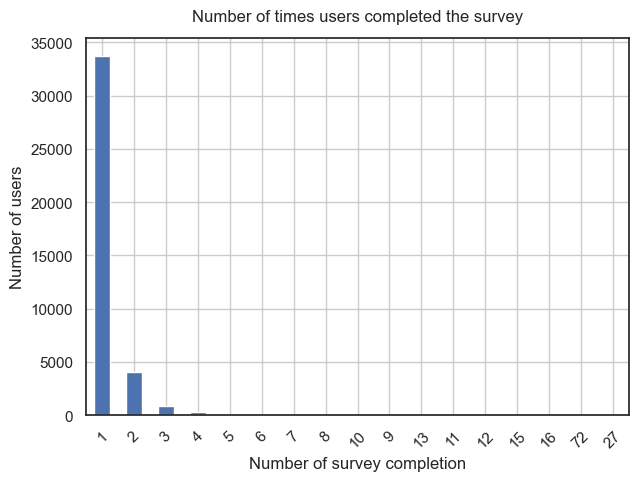

In [76]:
survey_results.groupby('user_pseudo_id').agg({'user_pseudo_id': 'count'})[
    'user_pseudo_id'].value_counts().plot(kind='bar')
plt.title('Number of times users completed the survey', pad=12)
plt.ylabel('Number of users')
plt.xlabel('Number of survey completion')
plt.xticks(rotation=45)
plt.grid()
plt.show()

Most of users only completed the survey once during the close to 2 month data period. 

Let's find out how users' sleep norm score has changed in their surveys

In [77]:
survey_pivot = survey_results.pivot_table(index='user_pseudo_id', values='sleep_norm', aggfunc=[
    'count', 'min', 'max']).reset_index()
survey_pivot.columns = ['user', 'count', 'first_score', 'last_score']
survey_pivot = survey_pivot[survey_pivot['count'] >1]
print(survey_pivot.shape[0])
survey_pivot

5504


user  count  first_score  last_score
2      00032234636c663b0f81e2101a0c6755      2        2.000       4.000
6      000d00f48b0f3d5051ca2cbeeeb83f09      2        4.000       4.000
8      000ea77a665fe8c3453f2b711e66d3df      2        8.000      10.000
11     00169f124d76db30f3d1737b147e4161      2        6.000       6.000
12     001716c48ec7b7b08ee8d6da0b230de5      2        4.000       8.000
...                                 ...    ...          ...         ...
39301  ffb20aca90f28cc5ecbc1918cf204f4e      2        6.000       6.000
39319  ffd833ca06a0549661696af36116bfea      2        2.000       4.000
39323  ffddac82b57030baef499429582df824      2        2.000       8.000
39327  ffe1fe29324b17b9b99ceba4c2d2c034      2        2.000       2.000
39339  fff3d3782c865e226e26075c70b60740      2        6.000       6.000

[5504 rows x 4 columns]

In [78]:
survey_pivot['change'] = survey_pivot['last_score'] - survey_pivot['first_score']

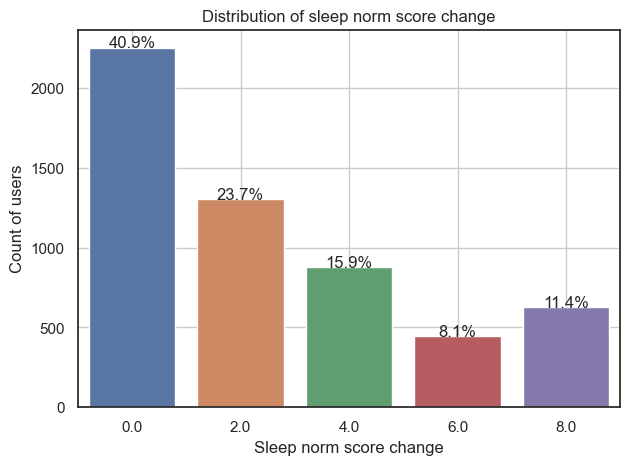

In [79]:
ax=sns.countplot(x='change', data=survey_pivot)
plt.title('Distribution of sleep norm score change')
plt.xlabel('Sleep norm score change')
plt.ylabel('Count of users')
plt.grid()
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(survey_pivot))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y),ha='center')
plt.show()

In [80]:
#take a look at the results for the sleep_norm item by country
df_sleep= survey_results.groupby('country')['sleep_norm'].describe().reset_index()

In [81]:
#the countries that has the lowest median sleep score
df_sleep[df_sleep['50%'] == df_sleep['50%'].min()]

country  count  mean   std   min   25%   50%    75%    max
4                Andorra  3.000 3.333 2.309 2.000 2.000 2.000  4.000  6.000
5                 Angola  9.000 4.222 3.528 2.000 2.000 2.000  6.000 10.000
18                 Benin  3.000 3.333 2.309 2.000 2.000 2.000  4.000  6.000
24                Brunei  1.000 2.000   NaN 2.000 2.000 2.000  2.000  2.000
26          Burkina Faso 14.000 4.000 2.935 2.000 2.000 2.000  5.500 10.000
27               Burundi  1.000 2.000   NaN 2.000 2.000 2.000  2.000  2.000
29              Cameroon 15.000 4.267 3.011 2.000 2.000 2.000  6.000 10.000
35               Comoros  6.000 3.000 1.673 2.000 2.000 2.000  3.500  6.000
36   Congo - Brazzaville  5.000 3.600 2.191 2.000 2.000 2.000  6.000  6.000
37      Congo - Kinshasa 21.000 3.048 1.746 2.000 2.000 2.000  4.000  8.000
43         Côte d’Ivoire 16.000 3.625 2.849 2.000 2.000 2.000  4.500 10.000
59                 Gabon  6.000 3.333 3.266 2.000 2.000 2.000  2.000 10.000
65               Grenada  1.000 2.000   NaN 2.000 2.000 2.000  2.000  2.000
115            Nicaragua 16.000 3.375 2.277 2.000 2.000 2.000  4.000 10.000
124     Papua New Guinea  1.000 2.000   NaN 2.000 2.000 2.000  2.000  2.000
130          Puerto Rico 12.000 5.000 3.861 2.000 2.000 2.000 10.000 10.000
146          South Sudan  1.000 2.000   NaN 2.000 2.000 2.000  2.000  2.000
157             Tanzania  3.000 4.667 4.619 2.000 2.000 2.000  6.000 10.000
159                 Togo  6.000 4.667 4.131 2.000 2.000 2.000  8.000 10.000
160    Trinidad & Tobago  5.000 3.600 2.191 2.000 2.000 2.000  6.000  6.000
164  U.S. Virgin Islands  1.000 2.000   NaN 2.000 2.000 2.000  2.000  2.000
165               Uganda  1.000 2.000   NaN 2.000 2.000 2.000  2.000  2.000
176             Zimbabwe  3.000 2.667 1.155 2.000 2.000 2.000  3.000  4.000

The above shows the countries with the lowest median sleep norm score in the survey. However, these seem to be the countries that also don't have many app users. 

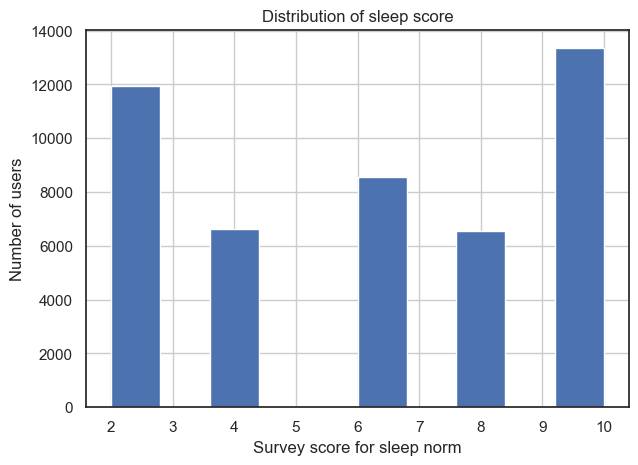

In [82]:
#plot the sleep score distribution
survey_results['sleep_norm'].hist(bins=10)
plt.title('Distribution of sleep score')
plt.xlabel('Survey score for sleep norm')
plt.ylabel('Number of users')
plt.show()

The above shows the score distribution for sleep norm. 

In [83]:
survey_results.groupby('country').agg({'user_pseudo_id': 'nunique', 'sleep_norm': 'median'}).sort_values(
    by='user_pseudo_id', ascending=False).head(10)

user_pseudo_id  sleep_norm
country                                  
Iran                    16911       6.000
Germany                  3830       6.000
Russia                   2021       6.000
Italy                    1577       6.000
Egypt                    1504       6.000
France                   1326       6.000
Turkey                   1078       6.000
Iraq                     1026       6.000
United States             780       6.000
Brazil                    550       6.000

The above shows the top 10 countries in terms of the number of unique users who participated in the survey. The median score for sleep norm interesting is all 6. 

### 7. App removal 

<a id="remove"></a>

In [84]:
#slice the data that has app removal event
events_remove = events_[events_['event_name'].str.contains("remove")]
print(events_remove.shape[0])
events_remove.head()

37685


user_pseudo_id  event_name  event_value_in_usd  \
341   e3fea79c661a6d436f9fb5c8953b5ec2  app_remove                 NaN   
536   977254cdf506c363db0c5c82502c26ae  app_remove                 NaN   
802   6660c103f27be47d4ea7506d6e0381ec  app_remove                 NaN   
854   1c14922f522562b356c146df6880c269  app_remove                 NaN   
1230  a9d6db2345b46c548f33974485486bee  app_remove                 NaN   

     platform  traffic  ltv device_category device_model continent  country  \
341   ANDROID  organic  NaN          mobile      MT7-L09    Europe  Germany   
536   ANDROID  organic  NaN          mobile     SM-N910C      Asia     Iran   
802   ANDROID  organic  NaN          mobile     SM-A715F      Asia     Iran   
854   ANDROID  organic  NaN          mobile     SM-J710F      Asia     Iran   
1230  ANDROID  organic  NaN          mobile   M2003J15SC      Asia     Iran   

     app_version       date            datetime previous_datetime  \
341        2.5.8 2021-05-15 2021-05-15 09:01:17               NaT   
536        2.5.7 2021-04-21 2021-04-21 08:19:34               NaT   
802        2.5.7 2021-04-21 2021-04-21 16:39:13               NaT   
854        2.5.7 2021-04-21 2021-04-21 14:14:37               NaT   
1230       2.5.7 2021-05-31 2021-05-31 18:34:54               NaT   

     first_touch_datetime                                       event_params  
341   2021-05-15 08:43:06  [{'key': 'ga_session_number', 'value': {'strin...  
536   2021-04-21 03:01:45  [{'key': 'firebase_event_origin', 'value': {'s...  
802   2021-04-20 06:50:13  [{'key': 'engaged_session_event', 'value': {'s...  
854   2021-04-11 08:49:22  [{'key': 'ga_session_number', 'value': {'strin...  
1230  2021-04-19 10:41:11  [{'key': 'firebase_event_origin', 'value': {'s...

In [85]:
#take a closer look
events_remove.sample().values

array([['296efb6ff65f183281a5e08b94658b39', 'app_remove', nan, 'ANDROID',
        'organic', nan, 'mobile', 'AMN-LX9', 'Asia', 'Iran', '2.5.8',
        Timestamp('2021-05-10 00:00:00'),
        Timestamp('2021-05-10 10:15:46'), NaT,
        Timestamp('2021-05-10 09:37:13'),
        array([{'key': 'engaged_session_event', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}},
               {'key': 'ga_session_id', 'value': {'string_value': None, 'int_value': 1620639434.0, 'float_value': None, 'double_value': None}},
               {'key': 'firebase_event_origin', 'value': {'string_value': 'auto', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'ga_session_number', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}}],
              dtype=object)                                                                                                                      ]],
   

Let's take a look at when users remove the app

In [86]:
def extract_session_number(lst):
    for dic in lst:
        if dic['key'] == 'ga_session_number':
            return dic['value']['int_value']

In [87]:
events_remove['session_number'] = events_remove['event_params'].apply(
    lambda x: extract_session_number(x))

In [88]:
events_remove['session_number'].describe()

count   36979.000
mean        3.258
std         4.870
min         1.000
25%         1.000
50%         2.000
75%         4.000
max       295.000
Name: session_number, dtype: float64

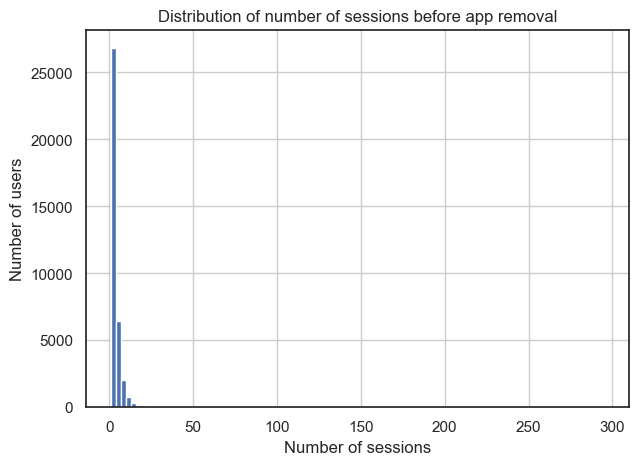

In [89]:
events_remove['session_number'].hist(bins=100)
plt.title('Distribution of number of sessions before app removal')
plt.xlabel('Number of sessions')
plt.ylabel('Number of users')
plt.show()

From above we can see that 75% of users remove the app at their 4th session. Barely any of them exceeds a total 20 sessions.

In [90]:
events_remove['platform'].value_counts()

ANDROID    37685
Name: platform, dtype: int64

All of those users are using an ANDROID device. 

In [91]:
events_remove['country'].value_counts()

Iran                        14672
Germany                      2904
Egypt                        1696
Italy                        1450
Russia                       1299
                            ...  
Cape Verde                      1
Guinea-Bissau                   1
St. Vincent & Grenadines        1
Curaçao                         1
Mayotte                         1
Name: country, Length: 188, dtype: int64

In [92]:
events_remove['user_pseudo_id'].nunique()

37545

Top countries where those user come from resemble the ranking of users total in general. 

There are 37545 unique users who have removed the app, 140 short than the total removals. This means there are users who remove the app more than once but still have the same user_pseudo_id.Next let's take a look at how long did the users stay with the app before the removal. 

In [93]:
events_remove['user_lifetime'] = events_remove['datetime'] - \
    events_remove['first_touch_datetime']

events_remove['user_lifetime'] = events_remove['user_lifetime'].dt.days

In [94]:
events_remove['user_lifetime'] = events_remove['user_lifetime'].fillna(0).astype('int')

In [95]:
#check how many of those are not valid
events_remove[events_remove['user_lifetime']<0].shape[0]

4

In [96]:
events_remove['user_lifetime'].describe()

count   37685.000
mean       33.260
std        57.388
min       -26.000
25%         0.000
50%         8.000
75%        42.000
max      4118.000
Name: user_lifetime, dtype: float64

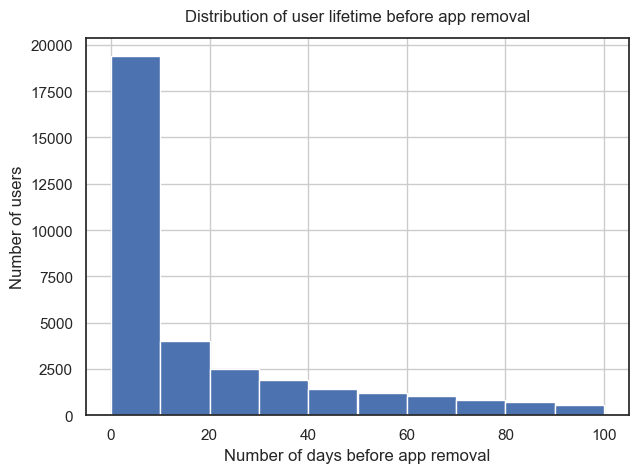

In [97]:
events_remove['user_lifetime'].hist(range=(0,100))
plt.title('Distribution of user lifetime before app removal', pad = 12)
plt.xlabel('Number of days before app removal')
plt.ylabel('Number of users')
plt.show()

More than half of the users removed the app within 10 days, 75% removed within 50 days. 

Next, Let's get the user_pseudo_id's of hte users who removed the app have a look at their usage journey. 

In [98]:
#get a slice of the data that contains all events for those who removed the app eventually
all_events_remove = events_[events_['user_pseudo_id'].isin(
    events_remove['user_pseudo_id'].to_list())]
all_events_remove.shape

(1965059, 16)

In [99]:
all_events_remove['user_pseudo_id'].nunique() / events['user_pseudo_id'].nunique()

0.48068059609771085

Almost half of the users in our data removed the app. 

### 9. Training unlock analysis

<a id="unlock"></a>

In [100]:
#slice the data that contain all the unlock related events 
events_unlock = events_[events_['event_name'].str.startswith("unlock")]
events_unlock.sample(5)

user_pseudo_id                 event_name  \
1738477  e7d3f4e102046984b8ac981f7be6b8d2          unlock_finish_qh6   
5194152  6d4078556e7b8477cb986366e13f1243           unlock_start_qh4   
435105   1ed173977fbff4b729fd5ccea61cff2a  unlock_click_for_free_qh1   
2480393  d865e3d5da757f4fd57c84cefefe2cc8               unlock_qh0_1   
4080277  6a9cecf43386272ccd9c1f4e1e0d0436  unlock_click_for_free_qh4   

         event_value_in_usd platform  traffic  ltv device_category  \
1738477                 NaN  ANDROID  organic  NaN          mobile   
5194152                 NaN  ANDROID  organic  NaN          mobile   
435105                  NaN  ANDROID  organic  NaN          mobile   
2480393                 NaN  ANDROID  organic  NaN          mobile   
4080277                 NaN  ANDROID  organic  NaN          mobile   

            device_model continent country app_version       date  \
1738477        SM-A205FN    Europe  Russia       2.5.7 2021-04-16   
5194152  Blade A7 2020RU    Europe  Russia       2.5.7 2021-04-20   
435105           POT-LX1      Asia  Turkey       2.6.1 2021-05-24   
2480393        SM-J600FN    Europe   Italy       2.5.8 2021-04-30   
4080277          JAT-L29    Europe   Italy       2.5.7 2021-04-13   

                   datetime   previous_datetime first_touch_datetime  \
1738477 2021-04-16 19:16:39                 NaT  2021-04-07 14:55:23   
5194152 2021-04-20 11:13:20                 NaT  2021-04-19 15:01:59   
435105  2021-05-24 10:56:29 2021-05-16 19:28:42  2021-05-13 13:44:19   
2480393 2021-04-30 12:08:08                 NaT  2021-04-29 14:04:04   
4080277 2021-04-13 20:33:47                 NaT  2021-04-13 20:23:17   

                                              event_params  
1738477  [{'key': 'firebase_screen_class', 'value': {'s...  
5194152  [{'key': 'engaged_session_event', 'value': {'s...  
435105   [{'key': 'firebase_screen_id', 'value': {'stri...  
2480393  [{'key': 'ga_session_number', 'value': {'strin...  
4080277  [{'key': 'engaged_session_event', 'value': {'s...

In [101]:
with pd.option_context('display.max_rows', None):
    display(events_unlock['event_name'].value_counts())

unlock_click_for_free_qh0           16408
unlock_start_qh0                    14957
unlock_qh0_1                         9788
unlock_click_for_free_qh2            6864
unlock_qh1_1                         6210
unlock_start_qh2                     6191
unlock_click_for_free_qh1            6142
unlock_start_qh1                     5431
unlock_click_for_free_qh4            5289
unlock_start_qh4                     4818
unlock_qh4_1                         4715
unlock_click_for_free_qh6            3854
unlock_qh6_1                         3852
unlock_start_qh6                     3474
unlock_qh2_1                         3189
unlock_click_for_free_qh5            2745
unlock_start_qh5                     2484
unlock_qh5_1                         1893
unlock_qh0_2                         1308
unlock_qh4_2                          667
unlock_qh0_3                          553
unlock_qh6_2                          430
unlock_qh2_2                          400
unlock_qh1_2                      

There are a total of 6 trainings that users can unlock for five days. 

In [102]:
# loop through the unlock events to event_name and calculate the completion rate
unlock_events = ['qh0', 'qh1', 'qh2', 'qh4', 'qh5', 'qh6']
event_start = []
event_finish = []
completion_rate = []

for event in unlock_events:
    start = ''.join(['unlock_start_', event])
    finish = ''.join(['unlock_finish_', event])
    print('The number of people who start the training {}:'.format(event),
          events_unlock[events_unlock['event_name'] == start].shape[0])
    event_start.append(
        events_unlock[events_unlock['event_name'] == start].shape[0])
    print('The number of people who finish the training {}:'.format(event),
          events_unlock[events_unlock['event_name'] == finish].shape[0])
    event_finish.append(
        events_unlock[events_unlock['event_name'] == finish].shape[0])
    print('Percentage users who finish the training {}:'.format(event), '{:.2%}'.format(
        events_unlock[events_unlock['event_name'] == finish].shape[0] /
        events_unlock[events_unlock['event_name'] == start].shape[0]))
    completion_rate.append(events_unlock[events_unlock['event_name'] == finish].shape[0] /
        events_unlock[events_unlock['event_name'] == start].shape[0])

The number of people who start the training qh0: 14957
The number of people who finish the training qh0: 238
Percentage users who finish the training qh0: 1.59%
The number of people who start the training qh1: 5431
The number of people who finish the training qh1: 85
Percentage users who finish the training qh1: 1.57%
The number of people who start the training qh2: 6191
The number of people who finish the training qh2: 118
Percentage users who finish the training qh2: 1.91%
The number of people who start the training qh4: 4818
The number of people who finish the training qh4: 133
Percentage users who finish the training qh4: 2.76%
The number of people who start the training qh5: 2484
The number of people who finish the training qh5: 62
Percentage users who finish the training qh5: 2.50%
The number of people who start the training qh6: 3474
The number of people who finish the training qh6: 104
Percentage users who finish the training qh6: 2.99%


qh0 training has the highest session start, at 14957. qh6 training has the highest finish rate, at 2.99%

In [103]:
unlock = pd.DataFrame({'event_name' : unlock_events,
                      'start' : event_start,
                      'finish': event_finish,
                      'completion_rate':completion_rate})
unlock

event_name  start  finish  completion_rate
0        qh0  14957     238            0.016
1        qh1   5431      85            0.016
2        qh2   6191     118            0.019
3        qh4   4818     133            0.028
4        qh5   2484      62            0.025
5        qh6   3474     104            0.030

In [104]:
#define a function to calculate the purchase rate for each training unlock
def purchase_rate(training):
    start = ''.join(['unlock_start_', training])
    finish = ''.join(['unlock_finish_', training])
    users_start = events_unlock[events_unlock['event_name']
                                == start]['user_pseudo_id'].unique()
    users_finish = events_unlock[events_unlock['event_name']
                                 == finish]['user_pseudo_id'].unique()
    users_purchase = events_[(events_['event_name']
                              == 'scr_premium') | (events_['event_name'] ==
                                                   'norbu_in_app_purchase')]['user_pseudo_id'].unique()
    # get users who didn't finish
    users_not_finish = [i for i in users_start if not i in users_finish]
    users_finish_purchase = [i for i in users_finish if i in users_purchase]
    users_not_finish_purchase = [
        i for i in users_not_finish if i in users_purchase]
    print("Number of users who didn't finish training {} but purchased: ".format(training))
    print(len(users_not_finish_purchase))
    print('Purchase rate for users who did not finish: {:.2%}'.format(
        len(users_not_finish_purchase)/len(users_not_finish)))
    print("Number of users who finished training {} and purchased: ".format(training))
    print(len(users_finish_purchase))
    if len(users_finish_purchase) != 0:
        print('Purchase rate for users who finished: {:.2%}'.format(
            len(users_finish_purchase)/len(users_finish)))
    else:
        print('Purchase rate for users who finished is 0')

In [105]:
#check out event qh0 as an example
purchase_rate('qh0')

Number of users who didn't finish training qh0 but purchased: 
81
Purchase rate for users who did not finish: 0.73%
Number of users who finished training qh0 and purchased: 
6
Purchase rate for users who finished: 2.52%


In [106]:
for event in unlock_events:
    purchase_rate(event)
    print('------------------------------------')

Number of users who didn't finish training qh0 but purchased: 
81
Purchase rate for users who did not finish: 0.73%
Number of users who finished training qh0 and purchased: 
6
Purchase rate for users who finished: 2.52%
------------------------------------
Number of users who didn't finish training qh1 but purchased: 
55
Purchase rate for users who did not finish: 1.16%
Number of users who finished training qh1 and purchased: 
3
Purchase rate for users who finished: 3.61%
------------------------------------
Number of users who didn't finish training qh2 but purchased: 
49
Purchase rate for users who did not finish: 0.95%
Number of users who finished training qh2 and purchased: 
3
Purchase rate for users who finished: 2.68%
------------------------------------
Number of users who didn't finish training qh4 but purchased: 
35
Purchase rate for users who did not finish: 0.87%
Number of users who finished training qh4 and purchased: 
9
Purchase rate for users who finished: 6.98%
---------

We can see overall, there is a higher purchase rate among those who finished the training than those who haven't. 

In [107]:
#take a look at the user journey who started the qh0 training (plotly may not show in code review)
plot_user_flow(events, 'unlock_start_qh0', 10, 5, title='from unlock_start_qh0')

### 9. In app purchase 

<a id="purchase"></a>

There are two in_app_purchase events in the data. We will use the norbu_in_app_purchase event as this one seems to be more complete. 

In [108]:
events_[events_['event_name'] == 'in_app_purchase'].shape[0]

207

In [109]:
#slice data with purchase 
events_purchase = events_[events_['event_name'] == 'norbu_in_app_purchase']
events_purchase.shape[0]

734

In [110]:
#slice sessions that are at the home screen of purchasing premium and those who made the purchase
events_premium = events_[(events_['event_name'] == 'scr_premium') | (
    events_['event_name'] == 'scr_getPremium')]
events_premium.shape[0]

9458

In [111]:
events_premium['event_name'].value_counts()

scr_getPremium    6971
scr_premium       2487
Name: event_name, dtype: int64

In [112]:
events_premium.sample().values

array([['fe225bc31e3388fb5072ea4d78b8e3c7', 'scr_getPremium', nan,
        'ANDROID', 'organic', nan, 'mobile', 'SM-G975F', 'Europe',
        'Belgium', '2.5.8', Timestamp('2021-05-24 00:00:00'),
        Timestamp('2021-05-24 16:31:17'), NaT,
        Timestamp('2021-05-24 16:28:26'),
        array([{'key': 'firebase_screen_class', 'value': {'string_value': 'MainActivity', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'engaged_session_event', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}},
               {'key': 'ga_session_number', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}},
               {'key': 'firebase_screen_id', 'value': {'string_value': None, 'int_value': 3.0967131590127744e+18, 'float_value': None, 'double_value': None}},
               {'key': 'firebase_event_origin', 'value': {'string_value': 'app', 'int_value': None, 'float_value': None,

Among those sessions that arrive at the home screen for premium purchase, 2487 actually resulted in a purchase. 

In [113]:
#check the purchase data details
events_purchase.sample().values

array([['D913BC5835DD413B8D90450810FEA031', 'norbu_in_app_purchase', nan,
        'IOS', '(none)', nan, 'mobile', 'iPhone', 'Asia', 'Georgia',
        '2.5.7', Timestamp('2021-04-10 00:00:00'),
        Timestamp('2021-04-10 20:51:40'), NaT,
        Timestamp('2021-04-10 20:47:50'),
        array([{'key': 'firebase_event_origin', 'value': {'string_value': 'app', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'engaged_session_event', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}},
               {'key': 'price', 'value': {'string_value': None, 'int_value': None, 'float_value': None, 'double_value': 179.0}},
               {'key': 'product_id', 'value': {'string_value': 'qh3', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'currency', 'value': {'string_value': '₽', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'ga_session_n

In [114]:
events_premium[events_premium['event_name'] == 'scr_premium'].sample().values

array([['7a35f87ddf2f1dc5aa16ef152128218c', 'scr_premium', nan,
        'ANDROID', 'organic', nan, 'mobile', 'SM-G570F', 'Asia', 'Iran',
        '2.5.7', Timestamp('2021-05-02 00:00:00'),
        Timestamp('2021-05-02 03:40:41'), NaT,
        Timestamp('2021-04-15 22:51:40'),
        array([{'key': 'firebase_screen_id', 'value': {'string_value': None, 'int_value': 6.495279593508686e+18, 'float_value': None, 'double_value': None}},
               {'key': 'engaged_session_event', 'value': {'string_value': None, 'int_value': 1.0, 'float_value': None, 'double_value': None}},
               {'key': 'ga_session_number', 'value': {'string_value': None, 'int_value': 5.0, 'float_value': None, 'double_value': None}},
               {'key': 'firebase_screen_class', 'value': {'string_value': 'MainActivity', 'int_value': None, 'float_value': None, 'double_value': None}},
               {'key': 'firebase_event_origin', 'value': {'string_value': 'app', 'int_value': None, 'float_value': None, 'double_

In [115]:
#extract session number to see when purchase are made
events_purchase['session_number'] = events_purchase['event_params'].apply(
    lambda x: extract_session_number(x))
events_premium['session_number'] = events_premium['event_params'].apply(
    lambda x: extract_session_number(x))

In [116]:
events_purchase['session_number'].describe()

count   732.000
mean      6.850
std      18.423
min       1.000
25%       1.000
50%       2.000
75%       5.000
max     202.000
Name: session_number, dtype: float64

In [117]:
events_premium['session_number'].describe()

count   9453.000
mean       5.304
std       10.874
min        1.000
25%        1.000
50%        2.000
75%        5.000
max      269.000
Name: session_number, dtype: float64

It seems that 75% of the purchases occur in the 5th session or before. 

In [118]:
def extract_purchase(lst):
    for dic in lst:
        if dic['key'] == 'product_id':
            return dic['value']['string_value']

In [119]:
events_purchase['purchase'] = events_purchase['event_params'].apply(
    lambda x: extract_purchase(x))

In [120]:
events_purchase['purchase'].value_counts()

app.norbu.premium    136
norbu_mounth         125
qh3                  121
qh0                   66
qh4                   43
qh1                   37
norbu_month_ios       33
norbu_annual          32
ch2                   32
qh5                   22
ch3                   22
qh2                   21
ch1                   17
qh6                   12
ch4                   12
norbu_annual_ios       3
Name: purchase, dtype: int64

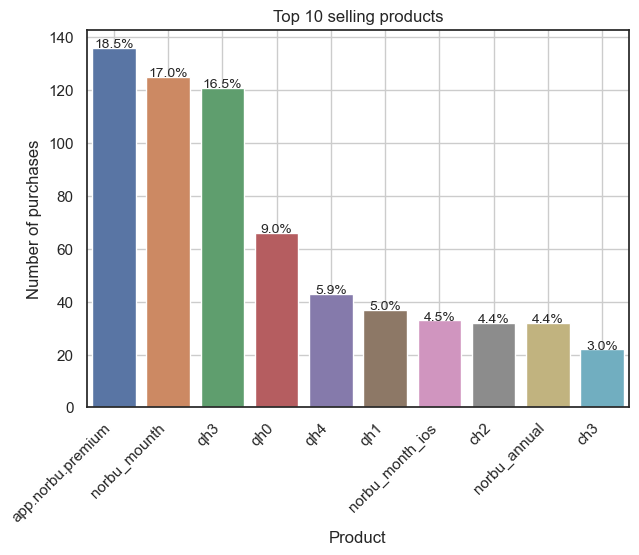

In [121]:
top_event = events_purchase.groupby('purchase').agg({'date': 'count'}).reset_index(
).sort_values(by='date', ascending=False).head(10)
ax = sns.barplot(data=top_event, x='purchase', y='date')
plt.title('Top 10 selling products')
plt.xlabel('Product')
plt.ylabel('Number of purchases')
plt.grid()
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/len(events_purchase))
    x = p.get_x() + p.get_width()/2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', size=10)
plt.xticks(rotation=45, ha='right')
plt.show()

The most purchased product is the premium package, followed by norbu_mounth, possibly a typo here. qh3 seems to be the most popular training that has been purchased. 

### 10. Meditation 

<a id="meditation"></a>

In [122]:
events_meditation = events_[events_['event_name'].str.contains('meditation')]
print(events_meditation.shape[0])

153699


In [123]:
events_meditation.sample(5)

user_pseudo_id          event_name  \
4969028  F29DB14756B34B3D8F9FB591E1AA7B96      scr_meditation   
1224479  63150f2e6501ed0a2b2619866e1cff7a  scr_meditationhome   
935225   0b17559b4754dd0b40a4b3df1dd37f06  scr_meditationhome   
2637215  2b61a952122c1d7811083bb24aa995e1   scr_bs_meditation   
2106022  3bed09bc7910761af5f46d6aa1c2c71a  scr_meditationhome   

         event_value_in_usd platform  traffic  ltv device_category  \
4969028                 NaN      IOS   (none)  NaN          mobile   
1224479                 NaN  ANDROID  organic  NaN          mobile   
935225                  NaN  ANDROID   (none)  NaN          mobile   
2637215                 NaN  ANDROID  organic  NaN          mobile   
2106022                 NaN  ANDROID  organic  NaN          mobile   

             device_model continent  country app_version       date  \
4969028         iPhone 6s    Europe    Italy       2.5.7 2021-05-01   
1224479   Mi Note 10 Lite    Europe  Ukraine       2.5.8 2021-05-03   
935225           SM-J700H    Europe  Germany       2.5.7 2021-04-24   
2637215  Redmi Note 8 Pro      Asia     Iran       2.5.7 2021-04-17   
2106022         SM-A307FN      Asia     Iran       2.5.8 2021-05-10   

                   datetime   previous_datetime first_touch_datetime  \
4969028 2021-05-01 19:46:54 2021-05-01 19:43:33  2021-04-30 06:01:11   
1224479 2021-05-03 15:57:03 2021-05-02 20:27:22  2021-05-01 04:39:44   
935225  2021-04-24 08:17:44 2021-04-24 08:14:22  2021-04-20 08:29:59   
2637215 2021-04-17 00:43:27                 NaT  2021-04-17 00:28:51   
2106022 2021-05-10 11:20:59 2021-05-10 11:16:35  2021-05-10 11:00:34   

                                              event_params  
4969028  [{'key': 'ga_session_id', 'value': {'string_va...  
1224479  [{'key': 'engaged_session_event', 'value': {'s...  
935225   [{'key': 'firebase_screen_id', 'value': {'stri...  
2637215  [{'key': 'firebase_event_origin', 'value': {'s...  
2106022  [{'key': 'firebase_screen_class', 'value': {'s...

In [124]:
events_meditation['platform'].value_counts()/events['platform'].value_counts()

ANDROID   0.029
IOS       0.032
Name: platform, dtype: float64

In [125]:
events_meditation['event_name'].value_counts()

scr_meditationhome    54614
scr_meditation        50458
result_meditation     30779
scr_bs_meditation     17845
scr_sc_meditation         3
Name: event_name, dtype: int64

In [126]:
number_home = events_meditation[events_meditation['event_name']
                                == 'scr_meditationhome'].shape[0]
number_start = events_meditation[events_meditation['event_name']
                                 == 'scr_meditation'].shape[0]
number_finish = events_meditation[events_meditation['event_name']
                                  == 'result_meditation'].shape[0]

print(
    'Percentage of who started the meditation from meditation home: {:.2%}'.format(number_start/number_home ))
print(
    'Percentage of who finished the meditation from meditation home: {:.2%}'.format(number_finish/number_home ))

Percentage of who started the meditation from meditation home: 92.39%
Percentage of who finished the meditation from meditation home: 56.36%


In [127]:
med_funnel = events_meditation[(events_meditation['event_name'] != 'scr_bs_meditation') & (
    events_meditation['event_name'] != 'scr_sc_meditation')]['event_name'].value_counts()

In [128]:
meditation_funnel = go.Figure(go.Funnel(
    y=med_funnel.index,
    x=med_funnel.values,
    textposition="inside",
    textinfo="value+percent initial"
))

meditation_funnel.update_layout(title={
    'text': "From meditation homescreen to meditation results",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    width=800, height=600)

meditation_funnel.show()

Approximately 56% of the users who were at the meditation homescreen completed the meditation training. Let's take a look at where others have gone next. 

In [129]:
#plot the user journey from stress management home screen 
plot_user_flow(events, 'scr_meditationhome', 5, 5, title = 'From scr_meditationhomel')

### 11. Game 

<a id="game"></a>

In [130]:
#slice the ball game data
events_ballsgame = events_[(events_['event_name'] == 'result_game') | (events_['event_name']
        == 'scr_ballshome') | (events_['event_name'] == 'scr_ballsgame')]

In [131]:
events_ballsgame.shape[0]

469142

In [132]:
events_ballsgame['event_name'].value_counts()

scr_ballshome    194087
scr_ballsgame    188211
result_game       86844
Name: event_name, dtype: int64

In [133]:
ball_funnel = go.Figure(go.Funnel(
    y=events_ballsgame['event_name'].value_counts().index,
    x=events_ballsgame['event_name'].value_counts().values,
    textposition="inside",
    textinfo="value+percent initial"
))

ball_funnel.update_layout(title={
    'text': "From ballgame home to resuls",
    'y': 0.9,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
    width=800, height=600)

ball_funnel.show()

45% of the sessions at ball game home screen actually went through to complete the game. Let's take a look at how the sessions divert. 

In [135]:
#plot the user journey from stress management home screen 
plot_user_flow(events, 'scr_ballshome', 5, 5, title = 'From ball game home screen')

### 12. User sessions 

<a id="max"></a>

In this section, let's have a quick look at how many sessions users usually had during the period of the data collection. 

In [136]:
events_['session_number'] = events_['event_params'].apply(
    lambda x: extract_session_number(x))
events_[events_['session_number'].isna()].shape[0]/events_.shape[0]

0.01832088586639003

In [137]:
events_['session_number'].describe()

count   5212239.000
mean         12.885
std          58.604
min           1.000
25%           1.000
50%           2.000
75%           6.000
max         723.000
Name: session_number, dtype: float64

In [138]:
events_.groupby('user_pseudo_id')['session_number'].max().describe()

count   76063.000
mean        4.920
std         9.640
min         1.000
25%         1.000
50%         3.000
75%         5.000
max       723.000
Name: session_number, dtype: float64

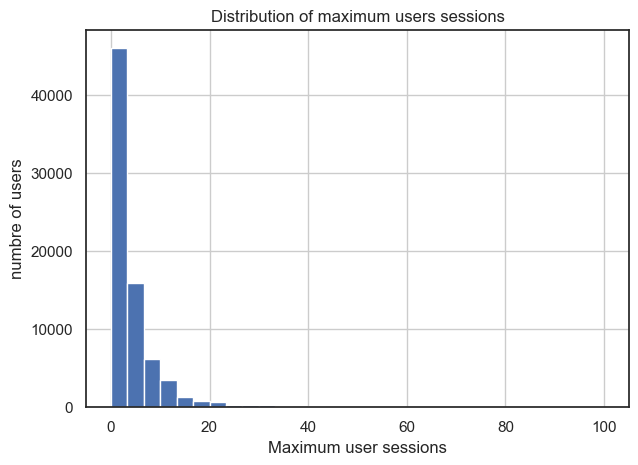

In [139]:
events_.groupby('user_pseudo_id')['session_number'].max().hist(bins=30, range=(0,100))
plt.title('Distribution of maximum users sessions')
plt.xlabel('Maximum user sessions')
plt.ylabel('numbre of users')
plt.show()

Half of the users have at most 3 sessions, 75% of the users have 5 sessions, with some extreme outliers extending to be beyond 100. 

### 13. Conclusion 

<a id="conclusion"></a>

Overall, the following issues have been noticed from the analysis:

- there is the lack of user information such as gender, age and key reason for using the app. Without such information it would be challenging to target users or personalize user experience 

- There is no obvious patterns in user journey. This might be normal, or might be the result of navigation problems. It is worth further investigation using method such as user experience interviews. 

- There are a large number of new users every day. Either purchase or removal happened within 5 sessions most of the time. Key to user retention is their experience in the first few sessions. 

- Unlock 5 day training shows low completion and purchase rate. The service will need to be further investigated. 

- low survey completion rate and most of the users only did the survey once within 2 months. 

- ball game seems to be popular and motivate more unified user journey. Maybe consider promote it on the homescreen packaged as"having trouble to focus? play this 3 minutes ball game" 

**Suggestion**

- add interface to the app to ask users simple questions in order to provide personalized training plan or programs; This will also allow the app to collect useful user information such as gender, age, and the key reason for them to use the app 

- simplify user decision making process and reduce the number of choices they have to make in order to pick the training. For example, provide them something like: 'here is what we think the most suitable training program for you' from the start. Then they can just go straight to that. 

- if survey is an important part of the journey, it needs to be prompted more. Users for example can get a reminder every 2 weeks to monitor their progress by completing the survey and if they show improvement they get some sort of encouraging message. 

- some alternating 'your meditation of the week' or 'stress relief training of the day' presented on homescreen with emphasis would be helpful too. 

- help users to create a habit. For example, ask them to schedule their 10 minute training in the calendear and so they get a reminder when it's time. 

In brief, users need to be told what to do. People nowadays don't think much when using apps and quite often just mindlessly scroll up and down and click on the shinniest button that catches their attention. In order to keep users, the app needs to give exactly what they need and make users feel the program is personalized for them, whether this is true or not. Imagine users open the screen and see this: 

                                      Hello Xia.
                                      How are you feeling at the moment? (options)
                                      Here is the best exercise for you today. It only takes 8 minutes. 
                                            ....
                                      Well done for taking the time to look after yourself. 
                                      If you would like to do to do anotehr exercise, click continue.
                                      If you are ready to go on with your day, click close. 
                                      Thank you and see you next time


